In [62]:
#Libraries and settings
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
 
url = '/content/drive/My Drive/اخابر.csv'
data1 = pd.read_csv(url, #index_col=['Date-S']
                    )
data1.head(10)

,Date-S,Date-G,Open,Close,Highest,Lowest,Last,Volume
0,13870519,20080809,1500,1500,1500,1500,1500,2230300000
1,13870520,20080810,1545,1545,1545,1545,1545,64168880
2,13870521,20080811,1591,1553,1591,1553,1553,3380431
3,13870522,20080812,1599,1556,1599,1556,1556,1062213
4,13870523,20080813,1602,1563,1602,1563,1563,2628987
5,13870526,20080816,1609,1570,1609,1570,1570,2899995
6,13870528,20080818,1617,1615,1617,1580,1615,263752470
7,13870529,20080819,1617,1595,1655,1568,1595,51973731
8,13870530,20080820,1580,1620,1642,1552,1620,40288734
9,13870602,20080823,1650,1638,1668,1638,1638,7321796


In [63]:
#descriptive statistics
data1.describe()

,Date-S,Date-G,Open,Close,Highest,Lowest,Last,Volume
count,2.522000e+03,2.522000e+03,2522.000000,2522.000000,2522.000000,2522.000000,2522.000000,2.522000e+03
mean,1.393056e+07,2.014267e+07,2771.473037,2772.749009,2805.255749,2733.337827,2767.065424,1.516675e+07
std,3.325044e+04,3.347841e+04,1612.502771,1591.238263,1630.482017,1581.888177,1612.236949,1.890308e+08
min,1.387052e+07,2.008081e+07,808.000000,1362.000000,1349.000000,808.000000,1335.000000,3.672000e+03
25%,1.390083e+07,2.011112e+07,2177.500000,2194.000000,2200.000000,2155.000000,2175.000000,1.738965e+06
50%,1.393061e+07,2.014087e+07,2349.000000,2352.000000,2373.500000,2315.000000,2341.500000,4.143740e+06
75%,1.396053e+07,2.017082e+07,2989.250000,2999.250000,3040.000000,2929.500000,2995.250000,1.077948e+07
max,1.399033e+07,2.020062e+07,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,9.174731e+09


In [64]:
#check missing values, show the number of missing values in the dataset.
data1.isnull().sum()

Date-S     0
Date-G     0
Open       0
Close      0
Highest    0
Lowest     0
Last       0
Volume     0
dtype: int64

In [65]:
# Sort DataFrame by date
df = data1.sort_values('Date-S')

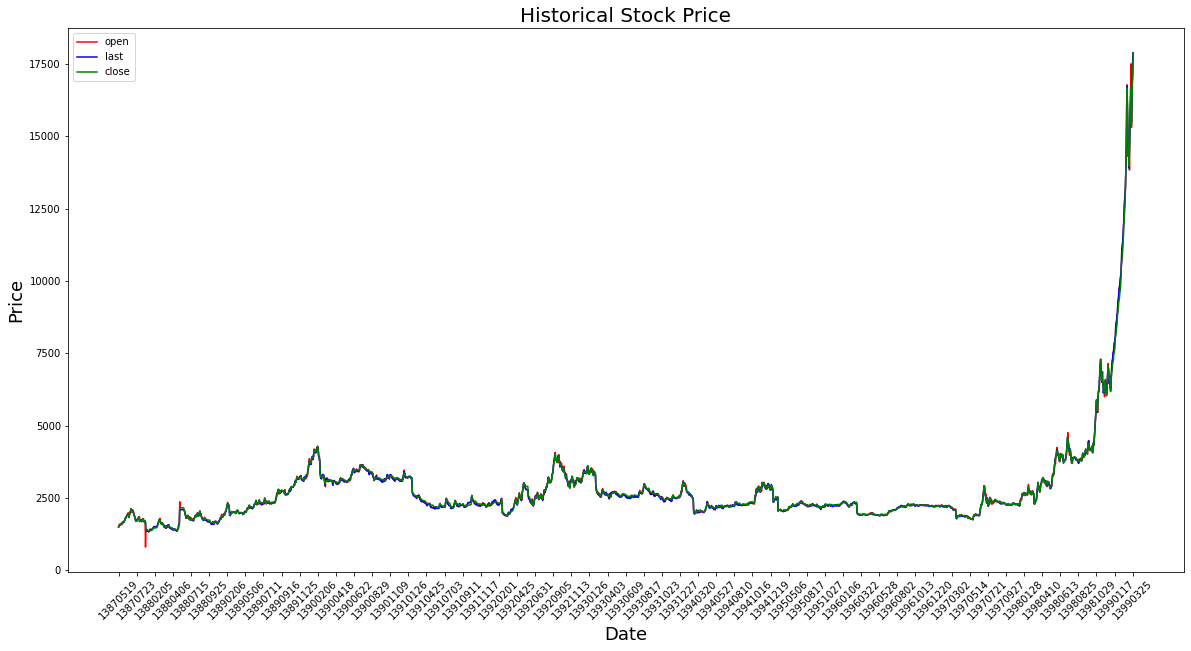

In [66]:
plt.figure(figsize=(20,10));
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Last.values, color='blue', label='last')
plt.plot(df.Close.values, color='green', label='close')
plt.xticks(range(0,df.shape[0],45), df['Date-S'].loc[::45], rotation=45)
plt.title('Historical Stock Price',fontsize=20)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.legend(loc='best')
plt.show()

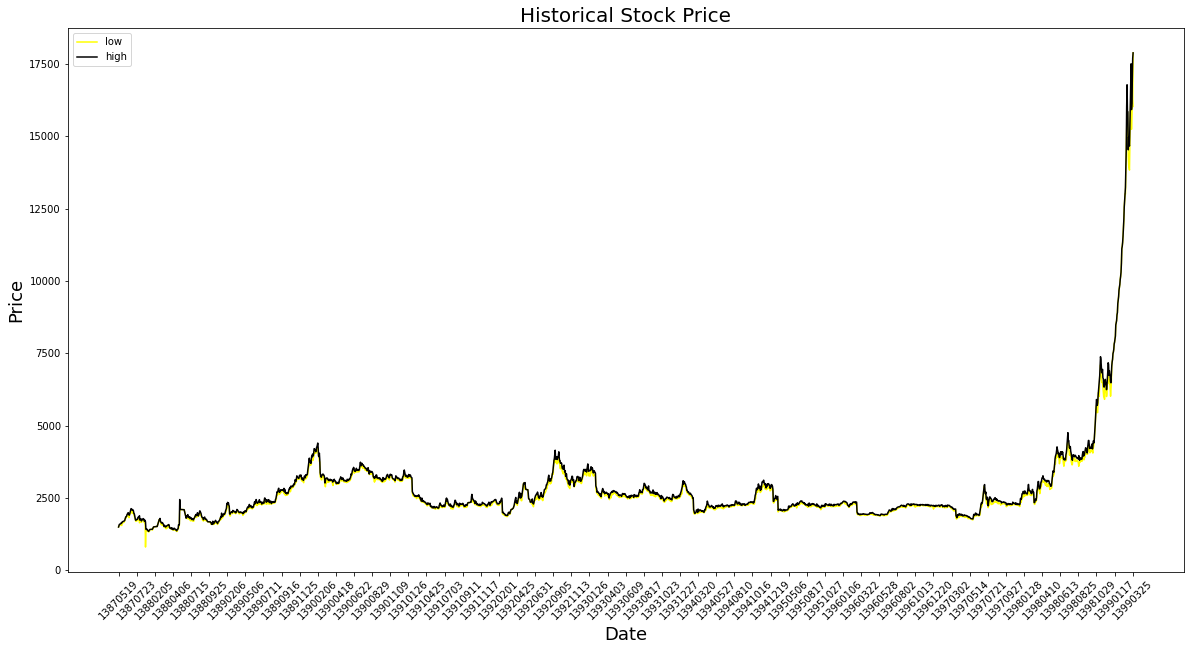

In [67]:
plt.figure(figsize=(20,10));
plt.plot(df.Lowest.values, color='yellow', label='low')
plt.plot(df.Highest.values, color='black', label='high')
plt.xticks(range(0,df.shape[0],45), df['Date-S'].loc[::45], rotation=45)
plt.title('Historical Stock Price',fontsize=20)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.legend(loc='best')
plt.show()

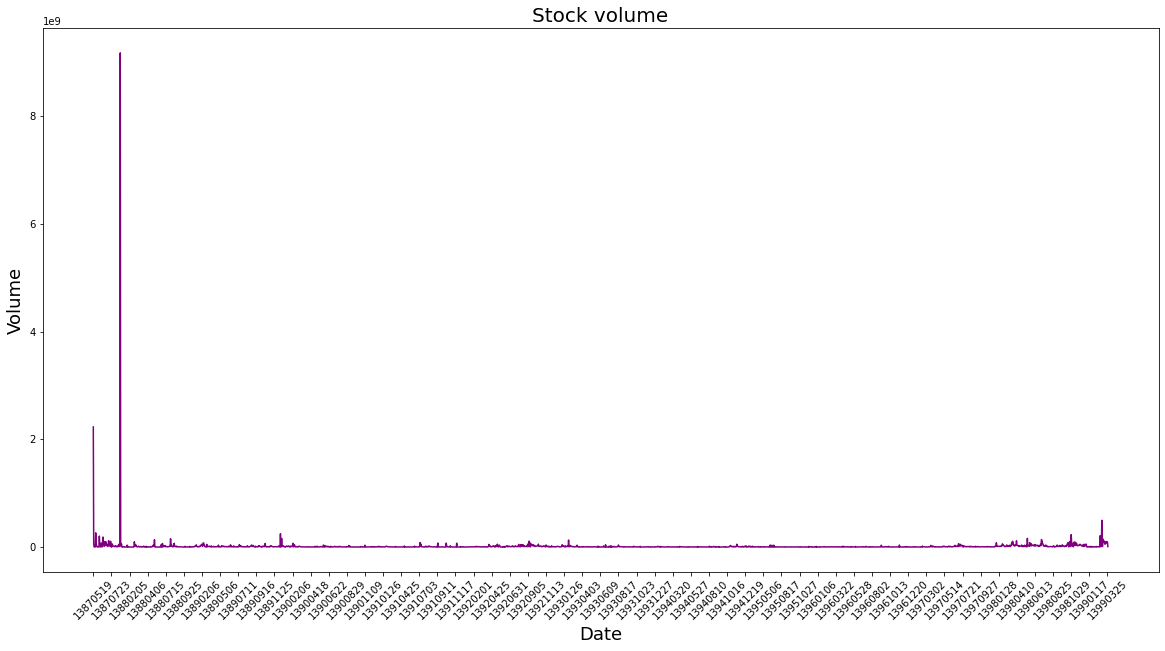

In [68]:
plt.figure(figsize=(20,10));
plt.plot(df.Volume.values, color='purple', label='volume')
plt.title('Stock volume',fontsize=20)
plt.xticks(range(0,df.shape[0],45), df['Date-S'].loc[::45], rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Volume',fontsize=18);

In [69]:
data1.tail()

,Date-S,Date-G,Open,Close,Highest,Lowest,Last,Volume
2517,13990320,20200609,15300,15375,15920,15240,15499,103601781
2518,13990321,20200610,15998,16118,16143,15623,16143,85739555
2519,13990324,20200613,16750,16850,16920,16250,16920,79411198
2520,13990325,20200614,17200,17030,17690,16010,17690,95462135
2521,13990326,20200615,17880,17880,17880,17880,17880,8395022


In [70]:
# Train & Test split
#data2 = pd.read_csv(url, index_col=['Date-S']
#                    )
#data2

data_train = data1.loc[:2285]#2.loc[:'13980325', :]
data_test = data1.loc[2285:]#2.loc['13980326':, :]
data_train.shape

(2286, 8)

In [71]:
# dimensionality reduction
data_train = data_train['Close']
data_test = data_test['Close']

In [72]:
pd.DataFrame(data_train)

,Close
0,1500
1,1545
2,1553
3,1556
4,1563
...,...
2281,2491
2282,2678
2283,2806
2284,2926


In [73]:
from numpy import array
import numpy as np
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 # define input sequence
raw_seq = data_train

# choose a number of time steps
n_steps_in, n_steps_out = 60,7 
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
print(X.shape, y.shape)
X

(2220, 60) (2220, 7)


array([[1500, 1545, 1553, ..., 1693, 1707, 1726],
       [1545, 1553, 1556, ..., 1707, 1726, 1738],
       [1553, 1556, 1563, ..., 1726, 1738, 1785],
       ...,
       [2258, 2270, 2266, ..., 2647, 2335, 2302],
       [2270, 2266, 2261, ..., 2335, 2302, 2347],
       [2266, 2261, 2269, ..., 2302, 2347, 2422]])

In [74]:
# Normalize just Close price
x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X)

pd.DataFrame(X_train)
  ######################## dar nahayat ba in kar mikonim az inja bebad

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,0.047244,0.062650,0.065389,0.066416,0.068812,0.071208,0.086614,0.079767,0.088326,0.094488,0.095173,0.096542,0.099966,0.103047,0.104759,0.121534,0.137966,0.149949,0.150976,0.156796,0.174940,0.182472,0.188976,0.197193,0.195139,0.176994,0.169463,0.188292,0.204724,0.224238,0.243410,0.260185,0.244437,0.225950,0.237932,0.243752,0.238959,0.218418,0.197877,0.184526,0.169120,0.150291,0.131804,0.114344,0.119822,0.120164,0.120507,0.137624,0.152687,0.140021,0.152687,0.165354,0.112290,0.117768,0.131462,0.134201,0.118453,0.113317,0.118110,0.124615
1,0.062650,0.065389,0.066416,0.068812,0.071208,0.086614,0.079767,0.088326,0.094488,0.095173,0.096542,0.099966,0.103047,0.104759,0.121534,0.137966,0.149949,0.150976,0.156796,0.174940,0.182472,0.188976,0.197193,0.195139,0.176994,0.169463,0.188292,0.204724,0.224238,0.243410,0.260185,0.244437,0.225950,0.237932,0.243752,0.238959,0.218418,0.197877,0.184526,0.169120,0.150291,0.131804,0.114344,0.119822,0.120164,0.120507,0.137624,0.152687,0.140021,0.152687,0.165354,0.112290,0.117768,0.131462,0.134201,0.118453,0.113317,0.118110,0.124615,0.128723
2,0.065389,0.066416,0.068812,0.071208,0.086614,0.079767,0.088326,0.094488,0.095173,0.096542,0.099966,0.103047,0.104759,0.121534,0.137966,0.149949,0.150976,0.156796,0.174940,0.182472,0.188976,0.197193,0.195139,0.176994,0.169463,0.188292,0.204724,0.224238,0.243410,0.260185,0.244437,0.225950,0.237932,0.243752,0.238959,0.218418,0.197877,0.184526,0.169120,0.150291,0.131804,0.114344,0.119822,0.120164,0.120507,0.137624,0.152687,0.140021,0.152687,0.165354,0.112290,0.117768,0.131462,0.134201,0.118453,0.113317,0.118110,0.124615,0.128723,0.144813
3,0.066416,0.068812,0.071208,0.086614,0.079767,0.088326,0.094488,0.095173,0.096542,0.099966,0.103047,0.104759,0.121534,0.137966,0.149949,0.150976,0.156796,0.174940,0.182472,0.188976,0.197193,0.195139,0.176994,0.169463,0.188292,0.204724,0.224238,0.243410,0.260185,0.244437,0.225950,0.237932,0.243752,0.238959,0.218418,0.197877,0.184526,0.169120,0.150291,0.131804,0.114344,0.119822,0.120164,0.120507,0.137624,0.152687,0.140021,0.152687,0.165354,0.112290,0.117768,0.131462,0.134201,0.118453,0.113317,0.118110,0.124615,0.128723,0.144813,0.127354
4,0.068812,0.071208,0.086614,0.079767,0.088326,0.094488,0.095173,0.096542,0.099966,0.103047,0.104759,0.121534,0.137966,0.149949,0.150976,0.156796,0.174940,0.182472,0.188976,0.197193,0.195139,0.176994,0.169463,0.188292,0.204724,0.224238,0.243410,0.260185,0.244437,0.225950,0.237932,0.243752,0.238959,0.218418,0.197877,0.184526,0.169120,0.150291,0.131804,0.114344,0.119822,0.120164,0.120507,0.137624,0.152687,0.140021,0.152687,0.165354,0.112290,0.117768,0.131462,0.134201,0.118453,0.113317,0.118110,0.124615,0.128723,0.144813,0.127354,0.110921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,0.308456,0.307429,0.306744,0.310852,0.309483,0.307771,0.310510,0.326600,0.324889,0.326258,0.323519,0.318384,0.314961,0.314618,0.317357,0.314618,0.313249,0.318042,0.313591,0.310852,0.311879,0.314618,0.311537,0.305033,0.303321,0.305717,0.368367,0.369736,0.359466,0.398836,0.432729,0.424170,0.428278,0.452585,0.447107,0.420062,0.444711,0.446765,0.438548,0.439575,0.436152,0.435467,0.432729,0.429647,0.456693,0.502568,0.529613,0.488874,0.448819,0.461143,0.457035,0.439233,0.432729,0.438891,0.426566,0.464909,0.473126,0.449161,0.453612,0.439918
2216,0.307429,0.306744,0.310852,0.309483,0.307771,0.310510,0.326600,0.324889,0.326258,0.323519,0.318384,0.314961,0.314618,0.317357,0.314618,0.313249,0.318042,0.313591,0.310852,0.311879,0.314618,0.311537,0.305033,0.303321,0.305717,0.368367,0.369736,0.359466,0.398836,0.432729,0.424170,0.428278,0.452585,0.447107,0.420062,0.444711,0

In [75]:
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y)
y_train
pd.DataFrame(y_train)

,0,1,2,3,4,5,6
0,0.128723,0.144813,0.127354,0.110921,0.109894,0.121876,0.106470
1,0.144813,0.127354,0.110921,0.109894,0.121876,0.106470,0.106470
2,0.127354,0.110921,0.109894,0.121876,0.106470,0.106470,0.011298
3,0.110921,0.109894,0.121876,0.106470,0.106470,0.011298,0.011298
4,0.109894,0.121876,0.106470,0.106470,0.011298,0.011298,0.011298
...,...,...,...,...,...,...,...
2215,0.333105,0.321808,0.337213,0.362889,0.358781,0.354331,0.386511
2216,0.321808,0.337213,0.362889,0.358781,0.354331,0.386511,0.450531
2217,0.337213,0.362889,0.358781,0.354331,0.386511,0.450531,0.494351
2218,0.362889,0.358781,0.354331,0.386511,0.450531,0.494351,0.535433


In [76]:
# function for min-max normalization of stock
stock = data1.loc[:2285]
sc = MinMaxScaler(feature_range = (0, 1))
set_scaled = sc.fit_transform(stock)
dsc = pd.DataFrame({'Open': set_scaled[:, 0],'Close':set_scaled[:,1],'Highest':set_scaled[:, 2],'Lowest':set_scaled[:,3],'Last':set_scaled[:,4],'Volume':set_scaled[:,5]})
date = stock.iloc[:,0:2]
norm = pd.concat([date, dsc],axis=1)
dd = pd.DataFrame(norm['Close'])
norm

,Date-S,Date-G,Open,Close,Highest,Lowest,Last,Volume
0,13870519,20080809,0.000000,0.000000,0.198679,0.047244,0.049492,0.202814
1,13870520,20080810,0.000009,0.000009,0.211599,0.062650,0.064241,0.216002
2,13870521,20080811,0.000018,0.000018,0.224806,0.065389,0.079318,0.218347
3,13870522,20080812,0.000027,0.000027,0.227103,0.066416,0.081940,0.219226
4,13870523,20080813,0.000036,0.000036,0.227964,0.068812,0.082924,0.221278
...,...,...,...,...,...,...,...,...
2281,13980320,20190610,0.999945,0.999945,0.465690,0.386511,0.382498,0.473623
2282,13980321,20190611,0.999954,0.999954,0.518806,0.450531,0.457555,0.529601
2283,13980322,20190612,0.999964,0.999964,0.557278,0.494351,0.479187,0.566530
2284,13980325,20190615,0.999991,0.999991,0.585702,0.535433,0.523435,0.584115


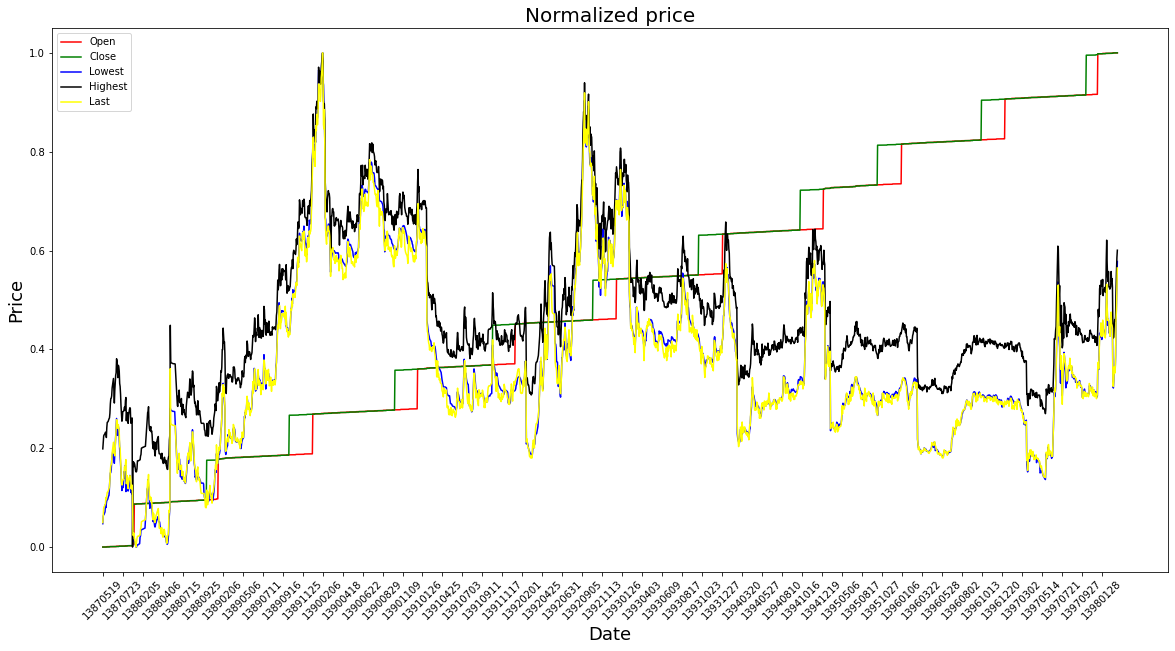

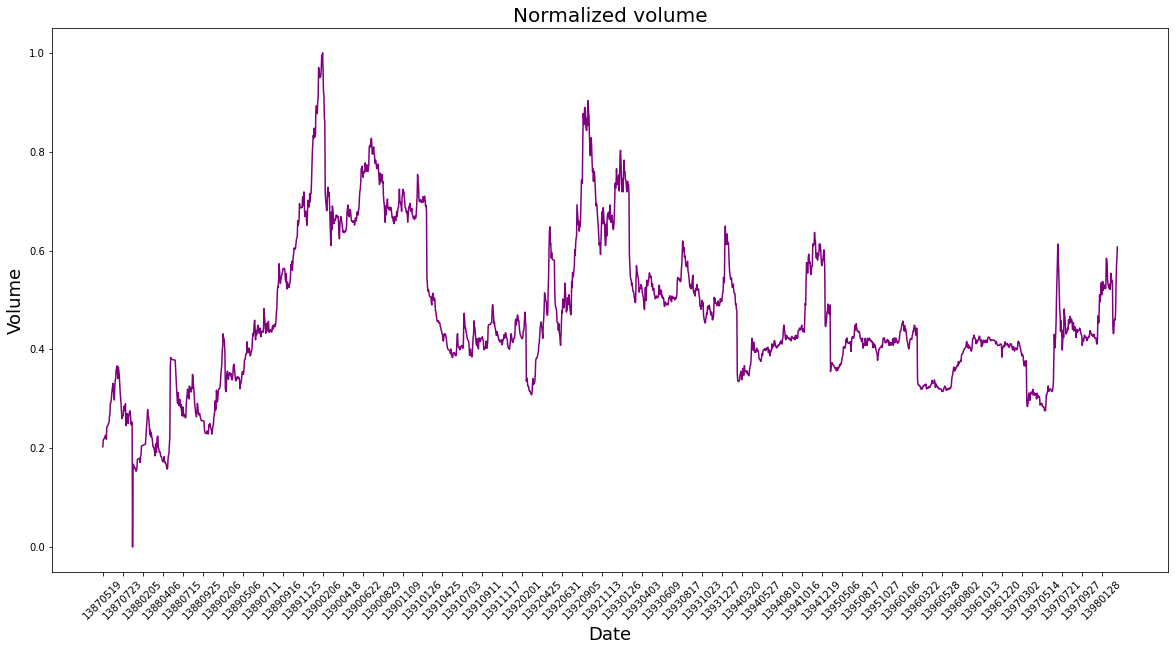

In [77]:
plt.figure(figsize=(20, 10));
plt.plot(norm.Open.values, color='red', label='Open')
plt.plot(norm.Close.values, color='green', label='Close')
plt.plot(norm.Lowest.values, color='blue', label='Lowest')
plt.plot(norm.Highest.values, color='black', label='Highest')
plt.plot(norm.Last.values, color='yellow', label='Last')
plt.title('Normalized price',fontsize=20)
plt.xticks(range(0,data1[:2285].shape[0],45), data1.loc[:2285]['Date-S'].loc[::45], rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(20, 10));
plt.plot(norm.Volume.values, color='purple', label='Volume')
plt.title('Normalized volume',fontsize=20)
plt.xticks(range(0,data1[:2285].shape[0],45), data1.loc[:2285]['Date-S'].loc[::45], rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Volume',fontsize=18)
plt.show()

In [78]:
# baraye shabake

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)
print(y_train.shape)
print(data_train.shape)

(2220, 60, 1)
(2220, 7)
(2286,)


In [79]:
# define model
model = Sequential()
model.add(LSTM(80, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(80, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 80)            26240     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 567       
Total params: 78,327
Trainable params: 78,327
Non-trainable params: 0
_________________________________________________________________


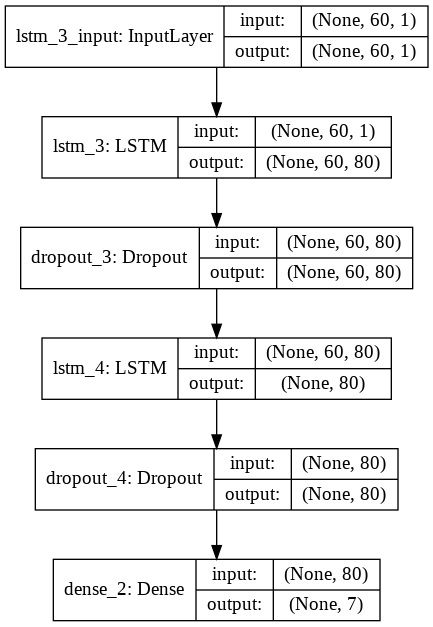

In [80]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [31]:
# fit model
history = model.fit(X_train, y_train, epochs=450, batch_size=64, verbose=2)

Epoch 1/450
 - 9s - loss: 0.0734 - accuracy: 0.1387
Epoch 2/450
 - 7s - loss: 0.0132 - accuracy: 0.1261
Epoch 3/450
 - 7s - loss: 0.0111 - accuracy: 0.1144
Epoch 4/450
 - 7s - loss: 0.0097 - accuracy: 0.1257
Epoch 5/450
 - 7s - loss: 0.0078 - accuracy: 0.1270
Epoch 6/450
 - 7s - loss: 0.0071 - accuracy: 0.1360
Epoch 7/450
 - 7s - loss: 0.0066 - accuracy: 0.1167
Epoch 8/450
 - 7s - loss: 0.0061 - accuracy: 0.1315
Epoch 9/450
 - 7s - loss: 0.0061 - accuracy: 0.1297
Epoch 10/450
 - 7s - loss: 0.0056 - accuracy: 0.1315
Epoch 11/450
 - 7s - loss: 0.0055 - accuracy: 0.1414
Epoch 12/450
 - 7s - loss: 0.0050 - accuracy: 0.1320
Epoch 13/450
 - 7s - loss: 0.0052 - accuracy: 0.1482
Epoch 14/450
 - 7s - loss: 0.0050 - accuracy: 0.1351
Epoch 15/450
 - 7s - loss: 0.0047 - accuracy: 0.1329
Epoch 16/450
 - 7s - loss: 0.0045 - accuracy: 0.1293
Epoch 17/450
 - 7s - loss: 0.0046 - accuracy: 0.1378
Epoch 18/450
 - 7s - loss: 0.0044 - accuracy: 0.1369
Epoch 19/450
 - 7s - loss: 0.0043 - accuracy: 0.1414
Ep

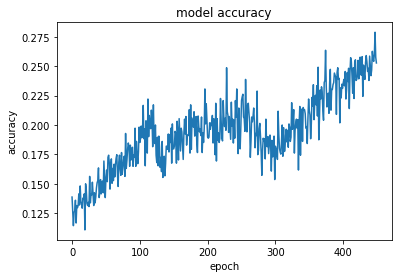

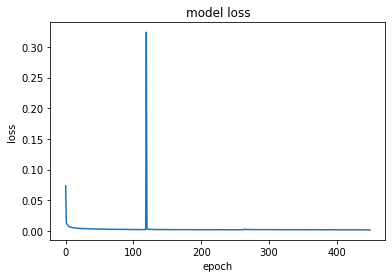

In [32]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [34]:
x_input = X_train
y_predT = model.predict(x_input, verbose=2)
# Visualising the results
y_predT = y_scaler.inverse_transform(y_predT)
print(y_predT)

y_trueT = y_scaler.inverse_transform(y_train)
print(y_trueT)

[[1737.2135 1737.8728 1739.3843 ... 1737.6945 1740.4049 1742.4973]
 [1744.9565 1746.0194 1747.8708 ... 1746.6173 1749.1312 1751.2063]
 [1791.7582 1793.877  1796.6467 ... 1797.0852 1800.5195 1802.9796]
 ...
 [2398.7205 2394.717  2397.1462 ... 2407.1714 2412.6394 2414.3867]
 [2377.2039 2374.4592 2376.8118 ... 2385.5393 2389.067  2390.0493]
 [2435.1973 2433.0305 2433.0493 ... 2429.3774 2426.7632 2424.6511]]
[[1738. 1785. 1734. ... 1683. 1718. 1673.]
 [1785. 1734. 1686. ... 1718. 1673. 1673.]
 [1734. 1686. 1683. ... 1673. 1673. 1395.]
 ...
 [2347. 2422. 2410. ... 2491. 2678. 2806.]
 [2422. 2410. 2397. ... 2678. 2806. 2926.]
 [2410. 2397. 2491. ... 2806. 2926. 3050.]]


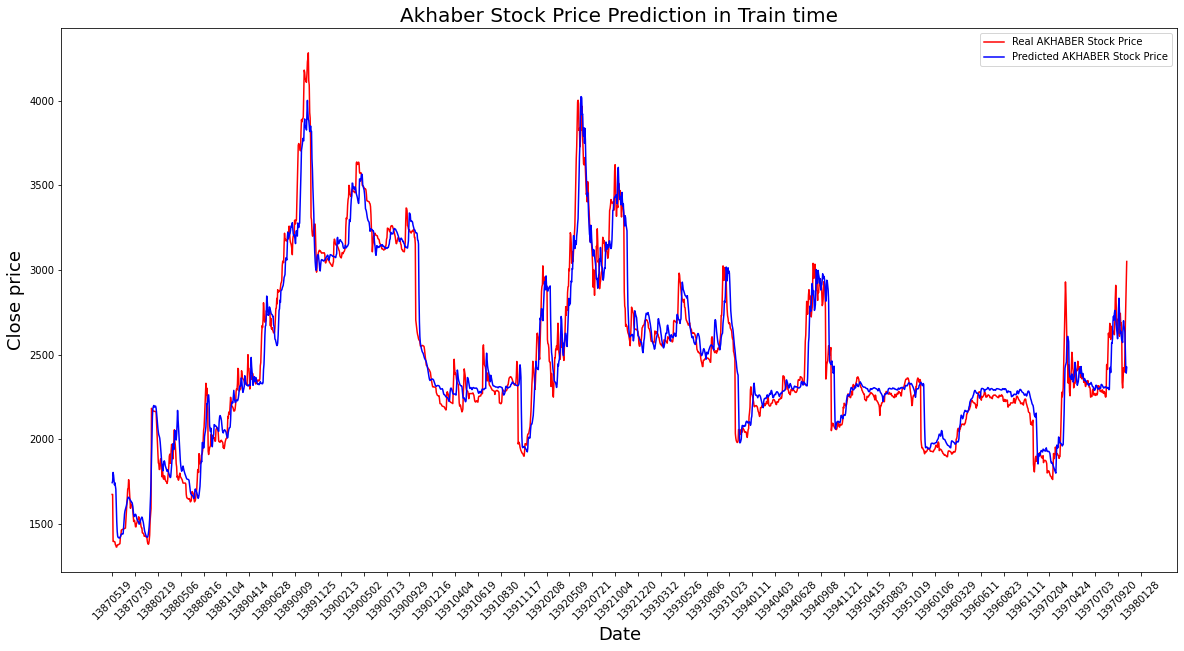

In [46]:
# Visualising the results
plt.figure(figsize=(20, 10));
plt.plot(y_trueT[:,6], color = 'red', label = 'Real AKHABER Stock Price')
plt.plot(y_predT[:,6], color = 'blue', label = 'Predicted AKHABER Stock Price')
plt.title('Akhaber Stock Price Prediction in Train time',fontsize=20)
plt.ylabel('Close price',fontsize=18)
plt.xticks(range(0,data1[:2285].shape[0],50), data1[:2285]['Date-S'].loc[::50], rotation=45)
plt.xlabel('Date',fontsize=18)
plt.legend()
plt.show()

In [47]:
#data_test = np.array(data_test)

X_test, y_test = [], []

from numpy import array
import numpy as np
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
 # define input sequence
raw_seq = data_test
# choose a number of time steps
n_steps_in, n_steps_out = 60,7 
# split into samples
X_test, y_test = split_sequence(raw_seq, n_steps_in, n_steps_out)
print(X_test.shape, y_test.shape)

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

x_scalerT = MinMaxScaler()
X_test = x_scalerT.fit_transform(X_test)

y_scalerT = MinMaxScaler()
y_test = y_scalerT.fit_transform(y_test)

pd.DataFrame(X_test)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test.shape

(171, 60) (171, 7)


(171, 7)

In [50]:
# rooye dade Test
x_input = X_test
y_predS = model.predict(x_input)
y_predS = y_scaler.inverse_transform(y_predS)
y_trueS = y_scaler.inverse_transform(y_test)
print(y_predS)
y_trueS

[[1441.754  1437.3783 1432.8292 ... 1410.7789 1399.967  1397.7418]
 [1459.8999 1457.3712 1454.8685 ... 1437.1989 1429.548  1428.2693]
 [1453.0353 1449.917  1446.545  ... 1429.9218 1424.2832 1424.5945]
 ...
 [3600.0413 3574.7896 3539.649  ... 3455.172  3419.3433 3387.3394]
 [3732.9526 3706.0007 3666.5198 ... 3559.5981 3516.7305 3482.242 ]
 [3810.5945 3780.5444 3736.9326 ... 3617.7734 3571.8936 3535.7834]]


array([[1423.00423859, 1431.10812269, 1401.39388101, ..., 1386.42864746,
        1379.08827721, 1385.47838962],
       [1431.10812269, 1401.39388101, 1363.57575524, ..., 1379.32213183,
        1386.97517438, 1387.74384827],
       [1401.39388101, 1363.57575524, 1386.76186806, ..., 1387.31696191,
        1389.38505963, 1383.21293097],
       ...,
       [3966.27319667, 4126.32490752, 4281.87446054, ..., 3955.43404546,
        4083.19860497, 4070.87069026],
       [4126.32490752, 4281.87446054, 4140.95692047, ..., 4120.43845511,
        4243.56551414, 4107.94183177],
       [4281.87446054, 4140.95692047, 3990.80995684, ..., 4283.        ,
        4283.        , 4283.        ]])

In [51]:
# evaluate network
#run the test dataset
test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print(
      "{} : {:.2f}%".format(model.metrics_names[1],
              test_error_rate[1]*100))
print(
      "{} : {:.2f}%".format(model.metrics_names[0],
              test_error_rate[0]*100))

#run the train dataset
train_error_rate = model.evaluate(X_train, y_train, verbose=2)
print(
      "{} : {:.2f}%".format(model.metrics_names[1],
              train_error_rate[1]*100))
print(
      "{} : {:.2f}%".format(model.metrics_names[0],
              train_error_rate[0]*100))

accuracy : 21.64%
loss : 0.45%
accuracy : 24.95%
loss : 0.13%


In [52]:
!sudo pip install h5py

In [53]:
# save network
model.save('Stack_Akhaber.h5')
from keras.models import load_model
# load model from single file
Univariate = load_model('Stack_Akhaber.h5')

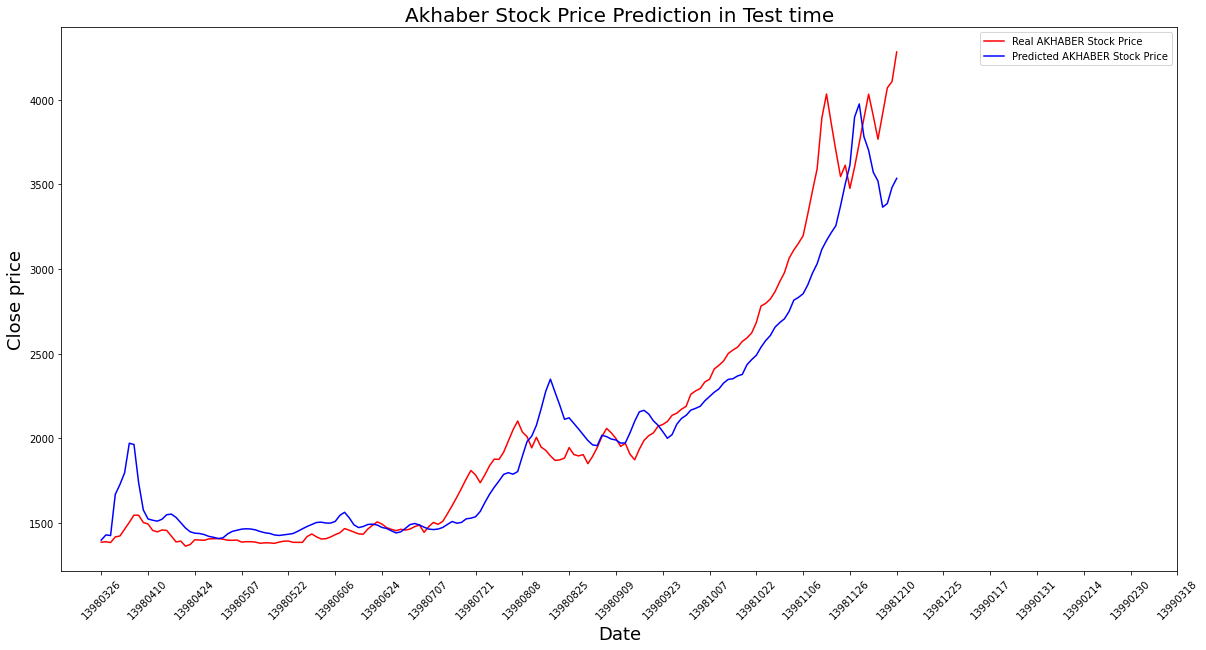

In [61]:
# Visualising the results
plt.figure(figsize=(20, 10));
plt.plot(y_trueS[:,6], color = 'red', label = 'Real AKHABER Stock Price')
plt.plot(y_predS[:,6], color = 'blue', label = 'Predicted AKHABER Stock Price')
plt.title('Akhaber Stock Price Prediction in Test time',fontsize=20)
plt.ylabel('Close price',fontsize=18)
plt.xticks(range(0,data1[2285:].shape[0],10), data1[2285:]['Date-S'].loc[::10], rotation=45)
plt.xlabel('Date',fontsize=18)
plt.legend()
plt.show()


In [58]:
print(X_train.shape)
print(y_train.shape)
print(y_predT.shape)
print(data_train.shape)
2286-2220

(2220, 60, 1)
(2220, 7)
(2220, 7)
(2286,)


66

In [59]:
# demonstrate prediction in 7 days of future
x_input = np.array(data_test[-n_steps_in:]) 
x_input = x_input.reshape((n_steps_in, 1))

scaler = MinMaxScaler()
x_input = scaler.fit_transform(x_input)

x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)
yhat = scaler.inverse_transform(yhat)
yhat

[[0.87590045 0.87247133 0.865919   0.8544029  0.840457   0.82900584
  0.8211137 ]]


array([[16427.414, 16387.277, 16310.582, 16175.786, 16012.549, 15878.514,
        15786.137]], dtype=float32)

In [ ]:
############### Final ################ --> model1